# Stark map of He

In [29]:
import HeStark.constants as con
from HeStark.q_defects import He_triplet_defect
from numerov import radial_integral
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.linalg import eigvalsh
import scipy as sp

%matplotlib notebook

Parameters

In [21]:
nmin = 35
nmax = 43
m = 0

mass = 4.0026*con.m_u;
corepole = (0.65)**3; # this is polarizability of Li+ => 0.191
Mred = con.m_e*(mass-con.m_e)/(con.m_e + (mass-con.m_e))
Ry_mass = 1.097373156853900e+05*Mred/con.m_e
a0 = con.a_0 * con.m_e/Mred

Fmin = 0       # minimum electric field strength V/cm
Fmax = 40    # maximum electric field strength V/cm
dF = 0.01       # step size for electric field strength V/cm
F=np.arange(Fmin,Fmax,dF)*100

Setting up the matrices

In [22]:
#Size of the matrix is given by ssM
ssM=0
for i in np.arange(nmin,nmax+1):
    for j in np.arange(m,i):
        ssM +=1

In [23]:
Md = sp.zeros([ssM,ssM]) #Diagonal matrix
MS = sp.zeros([ssM,ssM]) #Stark matrix

nn=sp.zeros([2,ssM,ssM],dtype='int') #label matrices
ll=sp.zeros([2,ssM,ssM],dtype='int')

nns=sp.zeros([2,ssM,ssM])

In [24]:
#Fill nn and ll labels 
Midx=0
for i in np.arange(nmin,nmax+1):
    for j in np.arange(m,i):
        nn[0,Midx,0:]=i
        ll[0,Midx,0:]=j
        Midx +=1
nn[1,:,:]=nn[0,:,:].transpose()
ll[1,:,:]=ll[0,:,:].transpose()

In [25]:
#enter diagonal elements by matching nn and ll of 1st dimension with nn and ll of 2nd dimension
for i in np.arange(0,ssM):
    for j in np.arange(0,ssM):
        nns[0,i,j]=nn[0,i,j]-He_triplet_defect(nn[0,i,j],ll[0,i,j])
        if (nn[0,i,j]-nn[1,i,j]==0 and ll[0,i,j]-ll[1,i,j]==0):
            Md[i,j]=-100*con.h*con.c*Ry_mass*(nns[0,i,j])**-2
nns[1,:,:]=nns[0,:,:].transpose()

In [26]:
#Electric field matrix
for i in np.arange(0,ssM):
    for j in np.arange(0,ssM):
        
        n1 = nns[0,i,j]
        n2 = nns[1,i,j]
        l1 = ll[0,i,j]
        l2 = ll[1,i,j]
        dl=l2-l1
        
        if abs(dl) == 1:
            Irad = radial_integral(n1,l1,n2,l2)
            if dl == 1:
                MS[i,j]=Irad * con.e *a0 * np.sqrt( ((l1+1)**2 - m**2) / ((2*l1 + 3)*(2*l1 + 1)) ) 
            elif dl == -1:
                MS[i,j]=Irad * con.e * a0 * np.sqrt( (l1**2 - m**2) / ((2*l1 + 1)*(2*l1 - 1)) )

In [27]:
E=np.zeros([ssM,len(F)])
#Find eigenvalues in joules and then convert to wavenumbers
for f in tqdm(np.arange(len(F))):
    M = Md+(F[f]*MS)
    E[:,f] = sp.sort(eigvalsh(M))
E=E/(100*con.h*con.c)

100%|█████████████████████████████████████| 4000/4000 [00:20<00:00, 191.68it/s]


Plotting

In [9]:
#Choose which n,l level is to be highlighted in the plot below
def colored_line(n_min,n,l):
    idc=0
    idn=[]
    while idc<n-n_min:
        a=n_min+idc
        idn.append(a)
        ids=sum(idn)+l
        
        idc +=1
    return ids

<IPython.core.display.Javascript object>


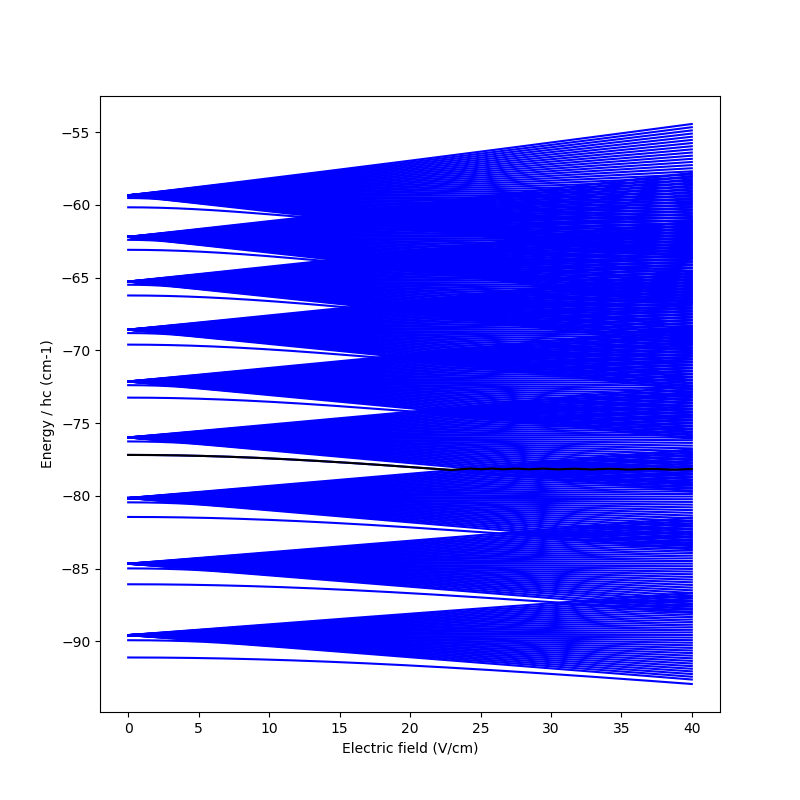

Text(0, 0.5, 'Energy / hc (cm-1)')

In [32]:
sE=E.shape
ids=colored_line(35,38,0)
fig, ax = plt.subplots(figsize=(8,8))
for i in np.arange(sE[0]):
    ax.plot(F*0.01,E[i,:],color='b')
ax.plot(F*0.01,E[ids,:],color='k')
ax.set_xlabel('Electric field (V/cm)')
ax.set_ylabel('Energy / hc (cm-1)')

<IPython.core.display.Javascript object>


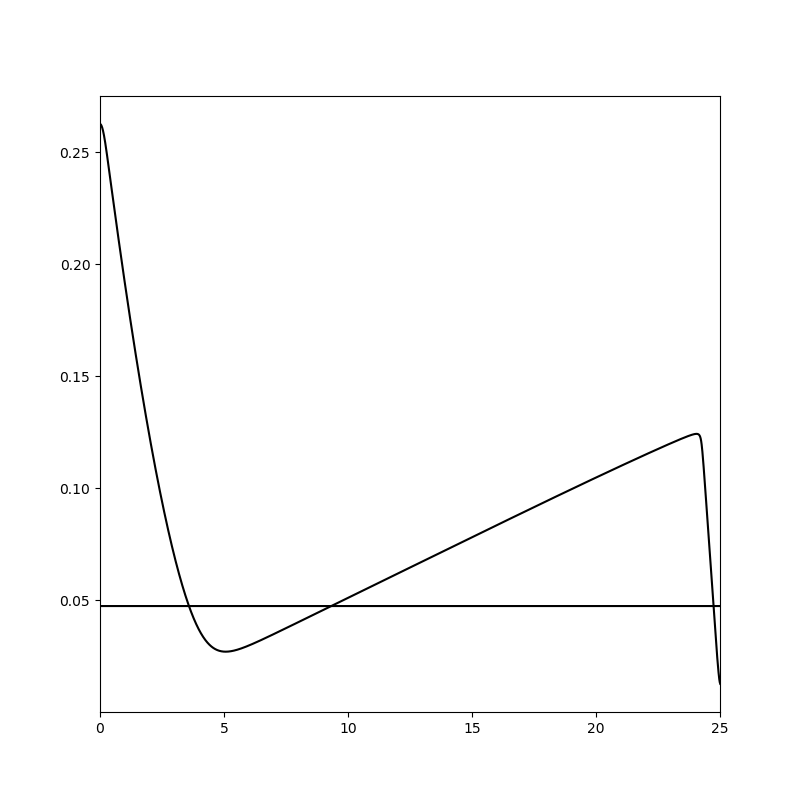

In [41]:
#Plot the difference between two states 
fig, ax = plt.subplots(figsize=(8,8))
state_1=colored_line(35,38,1)
state_2=colored_line(35,38,2)
ax.plot(F*0.01,E[state_2,:]-E[state_1,:],color='k')
ax.set_xlim(0,25)

#resonance with transition in another atom/molecule
tran = 0.04738 #in cm-1, hyperfine splitting in hydrogen
ax.plot(F*0.01,[tran]*len(F),color='k')